# Importation des modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from skimage import data

from PIL.Image import *

from imageio import imread
import glob
from tqdm import tnrange
from tqdm.notebook import tqdm
import torch
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image

In [2]:
torch.cuda.is_available()

True

# Test de modèle


## Chargement du dataset

In [3]:
size = 60

In [4]:
def image_to_numpy(image) :
    n = len(image)
    image_bis = []
    for i in range (n) :
        image_bis.append([])
        for j in range(n) :
            image_bis[i].append(image[i][j][0])
    return np.array(image_bis)

In [5]:
list_images = []
list_labels = []

id_courrant =""
for image_path in tqdm(glob.glob("transsup150/*.png")):
    image = imread(image_path)
    
    image = image_to_numpy(image)

    
    debut = 12
    label = image_path.find('l')
    couche = image_path.find('c')
    
    id_image = image_path[debut:couche]
    label_image = int(image_path[label+1:couche])
    
    if id_image == id_courrant :
        list_images[-1].append(image)
    else :
        id_courrant = id_image
        list_labels.append(label_image)
        list_images.append([image])

KeyboardInterrupt: 

In [18]:
len(list_labels)

40401

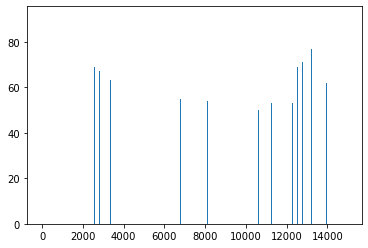

In [19]:
n = len(list_images)
num_label = plt.hist(list_labels, bins=range(max(list_labels)+2))

In [20]:
num_label = num_label[0]
deep=9

In [21]:
nouv_label = [-1]*(max(list_labels)+2)
compteur = 0
for i in range(max(list_labels)+1) :
    if num_label[i]>0 :
        nouv_label[i]=compteur
        compteur+=1

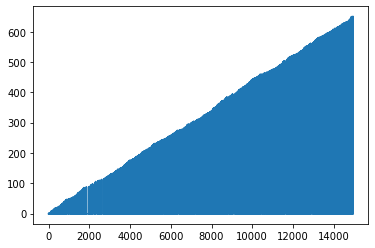

In [22]:
plt.plot(nouv_label)

In [23]:
label_max = max(nouv_label)
print(label_max)

651


In [24]:
nouv_list_labels = []
for i in range(len(list_labels)) :
    nouv_list_labels.append(nouv_label[list_labels[i]])

(array([68., 66., 64., 62., 64., 55., 59., 44., 69., 61., 69., 65., 53.,
        55., 69., 75., 70., 57., 59., 67., 45., 54., 62., 69., 68., 63.,
        53., 70., 76., 61., 59., 52., 54., 74., 79., 63., 56., 56., 62.,
        49., 55., 77., 58., 57., 47., 66., 61., 63., 52., 60., 70., 65.,
        74., 63., 59., 70., 62., 50., 79., 60., 71., 71., 51., 76., 64.,
        60., 69., 53., 58., 74., 63., 47., 57., 55., 69., 62., 74., 55.,
        64., 69., 61., 56., 67., 77., 67., 60., 68., 64., 54., 58., 48.,
        66., 56., 59., 67., 74., 71., 66., 65., 57., 72., 60., 81., 57.,
        62., 65., 53., 81., 77., 70., 54., 69., 61., 56., 54., 63., 76.,
        44., 67., 51., 50., 73., 70., 55., 69., 57., 55., 48., 62., 56.,
        53., 52., 56., 68., 72., 69., 67., 70., 58., 47., 50., 81., 73.,
        63., 65., 72., 51., 46., 62., 66., 60., 50., 67., 71., 67., 56.,
        62., 49., 53., 37., 71., 58., 62., 65., 72., 61., 59., 67., 64.,
        72., 54., 57., 53., 68., 46., 62., 80., 69.

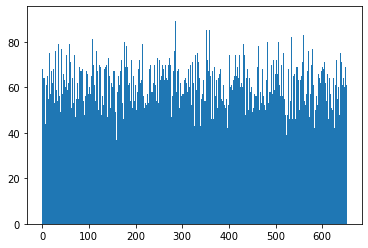

In [25]:
plt.hist(nouv_list_labels, bins=range(label_max +2))

In [26]:
num_classes = label_max+1
num_classes

652

In [27]:
def shuffle_in_unison(list_images, list_labels):
    assert len(list_images) == len(list_labels)
    shuffled_list_images = np.empty(list_images.shape, dtype=list_images.dtype)
    shuffled_list_labels = np.empty(list_labels.shape, dtype=list_labels.dtype)
    permutation = np.random.permutation(len(list_images))
    for old_index, new_index in enumerate(permutation):
        shuffled_list_images[new_index] = list_images[old_index]
        shuffled_list_labels[new_index] = list_labels[old_index]
    return shuffled_list_images, shuffled_list_labels

In [28]:
len(list_images[3])

9

In [29]:
def list_to_torch(list_images, list_labels) :
    n = len(list_images)
    
    torch_images=np.array([np.asarray(data) for data in list_images])
    torch_labels=np.array(list_labels)
    
    torch_images, torch_labels=shuffle_in_unison(torch_images, torch_labels)
    
    torch_images = torch.from_numpy(torch_images).cuda()
    torch_labels = torch.from_numpy(torch_labels).cuda()
    
    train_set = torch.utils.data.TensorDataset(torch_images[:int(0.8*n)],torch_labels[:int(0.8*n)])
    test_set = torch.utils.data.TensorDataset(torch_images[int(0.8*n):],torch_labels[int(0.8*n):])
    
    return train_set, test_set

In [30]:
train_set, test_set = list_to_torch(list_images, nouv_list_labels)

In [31]:
def train_epoch(net, train_set, opt, criterion, batch_size):
    net.train()
    trainloader = torch.utils.data.DataLoader(train_set, batch_size)
    for x_batch, y_batch in trainloader :
        opt.zero_grad()
        # Forward
        y_pred = net(x_batch.float())
        y_batch = y_batch.long()
        # Compute diff
        loss = criterion(y_pred, y_batch)
        # Compute gradients
        loss.backward()
        # update weights
        opt.step()

def accuracy(net, dataset):
    net.eval()
    correct = 0
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=1)
    for x_batch, y_batch in trainloader :
        y_pred = net(x_batch.float())
        y_pred = torch.argmax(y_pred).int()
        if int(y_pred)==int(y_batch[0]) :
            correct+=1
    return correct/len(dataset)

In [34]:
class Net(nn.Module):
    def __init__(self,size,deep_in, num_classes, deep_intern=36):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(deep_in,18,5,1,2)
        self.conv2 = nn.Conv2d(18,deep_intern,3,1,1)
        self.fc = nn.Linear(size*size*deep_intern//16,num_classes)
        self.size = size
        self.num_classes=num_classes
        self.deep_intern = deep_intern

    def forward(self, x):
        x = nn.MaxPool2d(2,None,0)(F.tanh(self.conv1(x)))
        x = nn.MaxPool2d(2,None,0)(F.tanh(self.conv2(x)))
        x = x.view(-1,self.size*self.size*self.deep_intern//16)
        x = self.fc(x)
        return x

In [33]:
def xavier(tensor) :
  with torch.no_grad():
    tensor=torch.tensor(np.random.randn(tensor.shape[0], tensor.shape[1])/np.sqrt(tensor.shape[0]))

In [36]:
def init_weights_xavier(m):
    if type(m) == nn.Linear:
      xavier(m.weight)

C:\Users\stani\anaconda3\envs\modal\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  app.launch_new_instance()


C:\Users\stani\anaconda3\envs\modal\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


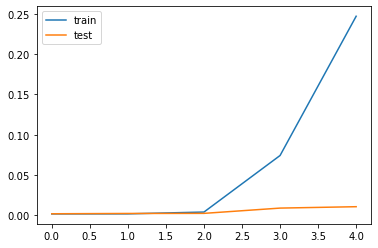

accuracy :


0.010518500185620592

In [37]:
epochs = 5
criterion = nn.CrossEntropyLoss()

net = Net(size, deep, num_classes).cuda()

net.apply(init_weights_xavier)


opt = torch.optim.Adam(net.parameters(),lr=1e-3,betas=(0.9, 0.999),eps=1e-08)

compteur = 0

preci_train = []
preci_test = []

for i in tnrange(epochs) :
    train_epoch(net, train_set, opt, criterion, batch_size=100)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label = "test")
plt.legend()
plt.show()

print("accuracy :") 
accuracy(net, test_set)

In [38]:
print(len(train_set))

32320


In [39]:
print(len(test_set))

8081


In [40]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()

        #first scale :
        self.first_scale = nn.Conv2d(in_planes, kernel_1_x, kernel_size=1, padding=0)

        #second scale :
        second_scale_1 = nn.Conv2d(in_planes, kernel_3_in, kernel_size=1, padding=0)
        second_scale_2 = nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1)

        self.second_scale = nn.Sequential(second_scale_1,second_scale_2)

        #third scale :
        third_scale_1 = nn.Conv2d(in_planes, kernel_5_in, kernel_size=1, padding=0)
        third_scale_2 = nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=5, padding=2)

        self.third_scale = nn.Sequential(third_scale_1,third_scale_2)


        #forth scale :
        forth_scale_1 = nn.MaxPool2d(3,1, padding=1)
        forth_scale_2 = nn.Conv2d(in_planes, pool_planes, kernel_size=1, padding=0)   
        
        self.forth_scale = nn.Sequential(forth_scale_1,forth_scale_2)


    def forward(self, x):
      
      x1 = self.first_scale(x)
      x2 = self.second_scale(x)
      x3 = self.third_scale(x)
      x4 = self.forth_scale(x)
        
      res = torch.cat([x1,x2,x3,x4],1)
      return res


class GoogLeNet(nn.Module):
    def __init__(self, input_dim=9):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(input_dim, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        
        self.layer1 = Inception(192,  64,  96, 128, 16, 32, 32)
        
        self.layer2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.layer3 = Inception(480, 192,  96, 208, 16,  48,  64)
        
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(512, num_classes)
        

    def forward(self, x):
        
        x = self.pre_layers(x)
        x = self.layer1(x)
        x = self.max_pool(x)
        x = self.layer2(x)
        x = self.max_pool(x)
        x = self.layer3(x)
        x = self.max_pool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


In [ ]:
print(torch.cuda.device_count())

In [ ]:
device = torch.device("cuda:0")
torch.cuda.get_device_name(0)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

In [ ]:
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

C:\Users\stani\anaconda3\envs\modal\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  del sys.path[0]


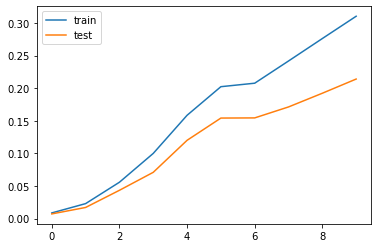

accuracy :


0.21408241554263086

In [41]:
epochs = 10
criterion = nn.CrossEntropyLoss()

net =  GoogLeNet().cuda()

opt = torch.optim.Adam(net.parameters(),lr=1e-3,betas=(0.9, 0.999),eps=1e-08)

compteur = 0

preci_train = []
preci_test = []

for i in tnrange(epochs) :
    train_epoch(net, train_set, opt, criterion, batch_size=10)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label = "test")
plt.legend()
plt.show()

print("accuracy :") 
accuracy(net, test_set)

C:\Users\stani\anaconda3\envs\modal\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """Entry point for launching an IPython kernel.


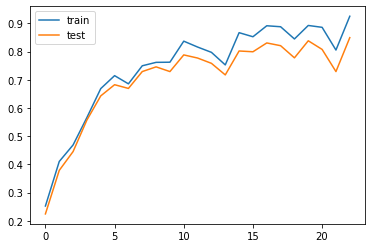

accuracy :


0.8496868475991649

In [29]:
for i in tnrange(20) :
    train_epoch(net, train_set, opt, criterion, batch_size=10)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label = "test")
plt.legend()
plt.show()

print("accuracy :") 
accuracy(net, test_set)

C:\Users\stani\anaconda3\envs\modal\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """Entry point for launching an IPython kernel.


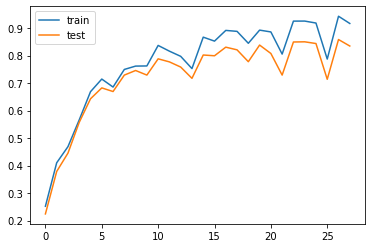

accuracy :


0.8350730688935282

In [30]:
for i in tnrange(5) :
    train_epoch(net, train_set, opt, criterion, batch_size=10)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label = "test")
plt.legend()
plt.show()

print("accuracy :") 
accuracy(net, test_set)